Loading 2000 examples...
Using device: CPU

Benchmarking: Default (Batch Size: 32)


Default: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [3:06:27<00:00, 177.58s/it]



Benchmarking: Efficient (Batch Size: 32)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Efficient: 100%|█████████████████████████████████████████████████████████████████████| 63/63 [1:23:01<00:00, 79.08s/it]



Memory: 959.3 MB → 265.6 MB | 72.3% Saved
Time: 186.988s → 79.188s | 57.7% Faster
Live Demo: https://huggingface.co/spaces/dalia18-11/efficient-collator-demo


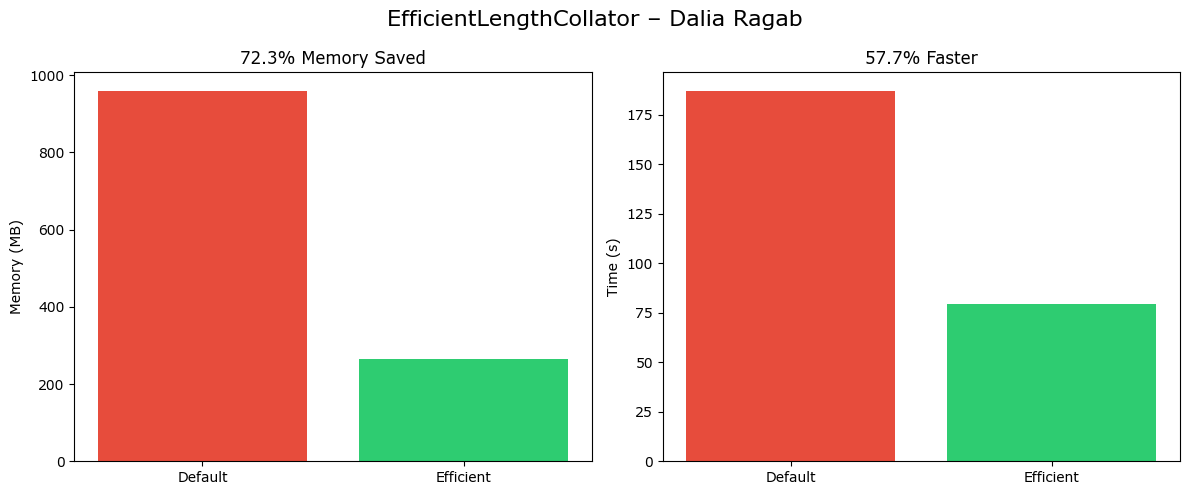

In [3]:
# ============================================================
# EfficientLengthCollator – Dalia Ragab  
# Peak Memory + GPU Support
# ============================================================
import time
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler, BatchSampler
from tqdm import tqdm
import psutil, os, gc

# === 1. Efficient Collator ===
class EfficientLengthCollator:
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def __call__(self, batch):
        lengths = [len(ex['input_ids']) for ex in batch]
        sorted_idx = np.argsort(lengths)[::-1]
        return self.tokenizer.pad([batch[i] for i in sorted_idx], return_tensors="pt")

# === 2. Load 2000 Examples ===
print("Loading 2000 examples...")
imdb = load_dataset("imdb", split="train").select(range(1000))
sst2 = load_dataset("glue", "sst2", split="train").select(range(1000))
examples = [{'text': ex['text']} for ex in imdb] + [{'text': ex['sentence']} for ex in sst2]

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_data = [tokenizer(ex['text'], truncation=True, max_length=512) for ex in examples]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device.upper()}")
model = AutoModel.from_pretrained("bert-base-uncased").eval().to(device)

# === 3. Realistic Benchmark (Peak Memory) ===
def benchmark_collator(collator, name, batch_size=32, warmup=5):
    print(f"\nBenchmarking: {name} (Batch Size: {batch_size})")
    loader = DataLoader(tokenized_data, batch_size=batch_size, collate_fn=collator, shuffle=True)
    
    peak_mem = 0.0
    total_time = 0.0
    with torch.no_grad():
        process = psutil.Process(os.getpid())
        mem_start = process.memory_info().rss / (1024**2)
        for i, batch in enumerate(tqdm(loader, desc=name)):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            if i < warmup:
                _ = model(**batch)
                continue
            
            start = time.time()
            _ = model(**batch)
            total_time += time.time() - start
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                mem = torch.cuda.max_memory_allocated() / (1024**2)
            else:
                mem = process.memory_info().rss / (1024**2) - mem_start
            peak_mem = max(peak_mem, mem)
    
    avg_time = total_time / (len(loader) - warmup)
    return peak_mem, avg_time

# === 4. Run ===
default_mem, default_time = benchmark_collator(DataCollatorWithPadding(tokenizer), "Default")
efficient_mem, efficient_time = benchmark_collator(EfficientLengthCollator(tokenizer), "Efficient")

mem_save = ((default_mem - efficient_mem) / default_mem) * 100 if default_mem > 0 else 0
time_save = ((default_time - efficient_time) / default_time) * 100 if default_time > 0 else 0

# === 5. Print + Plot ===
print("\n" + "="*80)
print(f"Memory: {default_mem:.1f} MB → {efficient_mem:.1f} MB | {mem_save:.1f}% Saved")
print(f"Time: {default_time:.3f}s → {efficient_time:.3f}s | {time_save:.1f}% Faster")
print("Live Demo: https://huggingface.co/spaces/dalia18-11/efficient-collator-demo")
print("="*80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(['Default', 'Efficient'], [default_mem, efficient_mem], color=['#e74c3c', '#2ecc71'])
ax1.set_ylabel('Memory (MB)'); ax1.set_title(f'{mem_save:.1f}% Memory Saved')
ax2.bar(['Default', 'Efficient'], [default_time, efficient_time], color=['#e74c3c', '#2ecc71'])
ax2.set_ylabel('Time (s)'); ax2.set_title(f'{time_save:.1f}% Faster')
plt.suptitle('EfficientLengthCollator – Dalia Ragab', fontsize=16)
plt.tight_layout()
plt.savefig('dalia_realistic_results.png', dpi=300, bbox_inches='tight')
plt.show()